# Protein-protein interaction docking analysis package

This package utilizes tools from [MDtraj](http://mdtraj.org/latest/index.html) and [nglview](http://arose.github.io/nglview/latest/index.html) to streamline analysis of protein-protein interaction docking solutions from servers such as ClusPro, Rosetta, Haddock, Swarmdock, Pie-Dock, etc. 

Docking solution (typically pdb) files are converted to an MDtraj-friendly format (this package currently only contains code for ClusPro conversion, but can be easily adapted to other file types). MDtraj is then used to calculate contact residues between docked proteins (using ***get_interface_contacts*** and ***contacts_iterator***), and then nglview is used to visually represent both individual docking solutions (via ***model_viewer***) and aggregate docking solutions (via ***atom_contacts_parser*** and ***heatmap***). Histograms of aggregate docking solution counts by residue, from N- to C-terminus, are also provided via ***docking_histograms***. 

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import mdtraj as md
import nglview as nv
import os
import itertools
import pickle

## The functions below define:

- a simple file conversion process (***mdtraj_converter***)

In [5]:
def mdtraj_converter(path):
    """
    Iterates through files in a user-specified directory and formats them for mdtraj input, 
    allowing mdtraj to read the files in as single-frame trajectories. Writes out new set of files
    labeled modeln.pdb (n = 0...n)
    """
    files = os.listdir(path)
    
    os.makedirs(path + "converted_models/")
                
    new_titles = []

    for i in range(len(files)):
        i = "model%s.pdb" % (i) 
        new_titles.append(i)
        
    def cluspro_converter(filename, output):
        """
        Re-formats cluspro pdb files so mdtraj can read them in as single-frame trajectories.  
        """
        f = open(filename)
        g = open(output, "w")

        for line in f.readlines():
            if line[:3] != "END":
                g.write(line)

        f.close()
        g.close()

    for i in range(len(files)):
        cluspro_converter(path + files[i], path + "converted_models/" + new_titles[i])

- interface contacts calculations (***get_interface_contacts***, ***contacts_iterator***)

In [8]:
def get_interface_contacts(frame, r_chains, l_chains, ca_cutoff_ang=10.):
    """
    Identify interface residues between ligand chains and receptor chains using mdtraj. 
    Residues identified by user-specified c-alpha cutoff, preset to 10 angstroms. 
    Feeds into contacts_iterator. 
    """
    
    #Get list of residues in receptor and ligand
    r_residues = []
    for chain in r_chains:
        r_residues.extend([residue.index for residue in frame.topology.chain(chain).residues])
    
    l_residues = []
    for chain in l_chains:
        l_residues.extend([residue.index for residue in frame.topology.chain(chain).residues])

    # Make an array of potential contact pairs between receptor and ligand
    contact_pairs = np.array([(i,j) for i in r_residues for j in l_residues])

    # Check which ones fall within c-alpha distance cutoff    
    is_contact = (10.*md.compute_contacts(frame, scheme='ca', contacts=contact_pairs)[0] < ca_cutoff_ang)[0]

    # Go from bool truth values to the actual residues
    contacts = contact_pairs[is_contact]

    # Go from pairs to flattened list of unique residues involved in contacts
    interface_residues = sorted(set(contacts[:,0]).union(set(contacts[:,1])))
    
    return interface_residues

In [9]:
def contacts_iterator(path, r_chains, l_chains):
    """
    Iterates through all files in a user-specified path (that have been edited by function mdtraj_converter 
    for mdtraj compatibility), calculates interface contacts using mdtraj_compute_contacts 
    (here called by function get_interface_contacts), pulls out all atom indices in each interface 
    and adds all interface atoms and interface residues to aggregate list of contacts. 
    Aggregate_contacts gets printed out into a file named "aggregate_contacts.txt" for later use, if needed. 
    Not currently mapped directly to file names, but aggregate_contacts[i] corresponds to all atom contacts within model[i].pdb.
    aggregate_contacts[i] feeds directly into model_viewer for viewing of individual docking solutions, with docking
    interface highlighted.    
    """

    files = os.listdir(path + "converted_models/")
    
    os.makedirs(path + "summary_data/")
    
    aggregate_contacts = []
    aggregate_residues = []
    
    for i in range(len(files)):
        i = "model%s.pdb" % (i) 
        pdb = md.load(path  + "converted_models/" + i)
        res = get_interface_contacts(pdb, r_chains, l_chains)
        aggregate_residues.append(res)
        
        atom_indices = []

        for i in res:
            a = [atom.index for atom in pdb.topology.residue(i).atoms]
            atom_indices.append(a)
    
        interface_atoms = np.hstack(atom_indices).tolist()
        aggregate_contacts.append(interface_atoms)
    
    with open(path + "summary_data/aggregate_contacts.pickle", "wb") as g:
        pickle.dump(aggregate_contacts, g)
    
    g.close()
        
    with open(path + "summary_data/aggregate_residues.pickle", "wb") as h:
        pickle.dump(aggregate_residues, h)
        
    h.close()
    
    return aggregate_contacts, aggregate_residues     

- callable individual docking solutions viewer (***model_viewer***)

In [10]:
def model_viewer(path, model_number, aggregate_contacts):
    """
    Quick viewer for visually inspecting docking contacts output. 
    Takes aggregate_contacts output from contacts_iterator and plots contacts (in red) 
    onto receptor-ligand docking solution (blue). 
    """
    
    pdb = md.load(path  + "converted_models/" + "model%s.pdb" % (model_number))
    
    view = nv.show_mdtraj(pdb)
    view.add_cartoon(selection ="protein", color = "blue")
    view.add_ball_and_stick(selection = aggregate_contacts[model_number], color = "red")
    
    return view

- aggregate docking solution hotspot histograms for receptor and ligand (***docking_histograms***)

In [11]:
def docking_histograms(aggregate_residues, path, l_chains):
    """
    Takes output aggregate_residues from contacts_iterator and plots histograms of docking hits by residue
    for both receptor and ligand. Requires path name for directory in which all docking pdb files are stored,
    as well as the list of l_chains you used for contacts_iterator - this allows the function to differentiate 
    between ligand and receptor residues. 
    """

    counts = {}

    for i in itertools.chain(*aggregate_residues):
        counts[i] = counts.get(i, 0) + 1
        
    all_resis = list(counts.keys())
    all_counts = list(counts.values())

    pdb = md.load(path + "converted_models/" + "model0.pdb")
    
    ligand_residue_1 = [residue.index for residue in pdb.topology.chain(l_chains[0]).residues][0]

    receptor_resis = []
    ligand_resis = []
    receptor_counts = []
    ligand_counts = []
    actual_ligand_resis = []
    
    for i in range(len(all_resis)):
        if all_resis[i] < ligand_residue_1:
            receptor_resis.append(all_resis[i])
            receptor_counts.append(all_counts[i])
        else:
            ligand_resis.append(all_resis[i])
            ligand_counts.append(all_counts[i])
            
    for i in range(len(ligand_resis)):
        actual_ligand_resis.append(ligand_resis[i]-ligand_residue_1)
    
    rec_fig = plt.figure()
    ax1 = rec_fig.add_subplot(1,1,1)
    ax1.bar(receptor_resis, receptor_counts)
    ax1.set_xlabel("Receptor residue #")
    ax1.set_ylabel("Counts")

    lig_fig = plt.figure()
    ax2 = lig_fig.add_subplot(1,1,1)
    ax2.bar(actual_ligand_resis, ligand_counts, color ="g")
    ax2.set_xlabel("Ligand residue #")
    ax2.set_ylabel("Counts")

    plt.show()
    
    return receptor_resis, receptor_counts, ligand_resis, ligand_counts, actual_ligand_resis

- heatmap depiction of aggregate docking solutions mapped onto receptor and ligand structures (***atom_contacts_parser***, ***heatmap***)

In [12]:
def atom_contacts_parser(aggregate_contacts, path, l_chains):
    """
    Parses through aggregate_contacts data from contacts_iterator and spits out 
    contacted receptor_atoms and ligand_atoms, and their corresponding counts. 
    This data feeds into the heatmap viewer. 
    """

    counts = {}

    for i in itertools.chain(*aggregate_contacts):
            counts[i] = counts.get(i, 0) + 1

    all_contacts = list(counts.keys())
    all_counts = list(counts.values())

    pdb = md.load(path + "converted_models/" + "model0.pdb")

    ligand_atom_1 = [atom.index for atom in pdb.topology.chain(l_chains[0]).atoms][0]

    receptor_atoms = []
    ligand_atoms = []
    actual_ligand_atoms = []
    receptor_atom_counts = []
    ligand_atom_counts = []

    for i in range(len(all_contacts)):
        if all_contacts[i] < ligand_atom_1:
            receptor_atoms.append(all_contacts[i])
            receptor_atom_counts.append(all_counts[i])
        else:
            ligand_atoms.append(all_contacts[i])
            ligand_atom_counts.append(all_counts[i])
            
    receptor_atoms = np.hstack(receptor_atoms).tolist()
    ligand_atoms = np.hstack(ligand_atoms).tolist()
    receptor_atom_counts = np.hstack(receptor_atom_counts).tolist()
    ligand_atom_counts = np.hstack(ligand_atom_counts).tolist()
    
    for i in range(len(ligand_atoms)):
        actual_ligand_atoms.append(ligand_atoms[i]-ligand_atom_1)
        
    actual_ligand_atoms = np.hstack(actual_ligand_atoms).tolist()    

    return receptor_atoms, receptor_atom_counts, actual_ligand_atoms, ligand_atoms, ligand_atom_counts

In [13]:
def heatmap(path, r_chains, l_chains, plot_receptor = True, plot_ligand = False):
    """
    Constructs a heatmap of contact points onto receptor and ligand structures.
    Requires input from atom_contacts_parser. Color cutoffs are currently hard-coded
    for this particular data set, but can be easily modified. 
    """
    pdb = md.load(path + "converted_models/model0.pdb")
    
    rec = []

    for i in range(len(r_chains)):
        c = [atom.index for atom in pdb.topology.chain(r_chains[i]).atoms]
        rec.append(c)
            
    rec = np.array(rec)
    rec = np.hstack(rec).tolist()
    rec_structure = md.load(path + "converted_models/model0.pdb", atom_indices=rec)
    
    lig = []

    for i in range(len(l_chains)):
        c = [atom.index for atom in pdb.topology.chain(l_chains[i]).atoms]
        lig.append(c)
            
    lig = np.array(lig)
    lig = np.hstack(lig).tolist()
    lig_structure = md.load(path + "converted_models/model0.pdb", atom_indices=lig)

    if plot_receptor == True:
    
        view = nv.show_mdtraj(rec_structure)
        view.clear()
        view.add_ball_and_stick(selection ="residue", color = "blue")

        low = []
        med = []
        hi = []
        
        for i in range(len(receptor_atoms)):
            if receptor_atom_counts[i] > 1 and receptor_atom_counts[i] < 6:
                low.append(receptor_atoms[i])
            elif receptor_atom_counts[i] > 5 and receptor_atom_counts[i] < 11:
                med.append(receptor_atoms[i])
            else:
                hi.append(receptor_atoms[i])

        view.add_ball_and_stick(selection = low, color = "yellow")
        view.add_ball_and_stick(selection = med, color = "orange")
        view.add_ball_and_stick(selection = hi, color = "red")
        
    if plot_ligand == True:
    
        view = nv.show_mdtraj(lig_structure)
        view.clear()
        view.add_ball_and_stick(selection ="residue", color = "blue")

        l = []
        m = []
        h = []

        for i in range(len(actual_ligand_atoms)):
            if ligand_atom_counts[i] > 6 and ligand_atom_counts[i] < 26:
                l.append(actual_ligand_atoms[i])
            elif ligand_atom_counts[i] > 25 and ligand_atom_counts[i] < 51:
                m.append(actual_ligand_atoms[i])
            else:
                h.append(actual_ligand_atoms[i])

        view.add_ball_and_stick(selection = l, color = "yellow")
        view.add_ball_and_stick(selection = m, color = "orange")
        view.add_ball_and_stick(selection = h, color = "red")
        
    return view

## *Example usage*

#### User specifies path to docking solution files and specifies ligand and receptor chains within files. 

In [15]:
#a subset of data files (20) from a TLR4/S100A9 ClusPro docking solutions set
path = "data_files/"

#TLR4 receptor chains 
r_chains = [0,1,2,3]

#S100A9 receptor chains
l_chains = [4,5]

#### Convert files to mdtraj-friendly format

In [16]:
mdtraj_converter(path)

#### Calculate contacts for all docking solutions

In [17]:
#iterates through all files in user-specified directory and calculates contacts within user-specified
#C-alpha distance cutoff between receptor and ligand chains. Both aggregate contact atoms and aggregate
#contact residues are returned - aggregate_contacts are used to plot single-model solutions using model_viewer,
#while aggregate_residues are used for docking_histograms and heatmap. 

aggregate_contacts, aggregate_residues = contacts_iterator(path, r_chains, l_chains)

#### View individual docking solutions

*Side note - aggregate_contacts and aggregate_residues are saved as pickle files in summary_data in case of issues,
as the distance calculation can take a while for a large set of files if you need to repeat it. 
These are easily imported for use with other functions, e.g.*

```python
with open(path + "summary_data/aggregate_contacts.pickle", "rb") as f:
    aggregate_contacts = pickle.load(f)

with open(path + "summary_data/aggregate_residues.pickle", "rb") as g:
    aggregate_residues = pickle.load(g)
```

In [20]:
#number specification corresponds to model_number, e.g. 0 = model0.pdb.

model_viewer(path, 0, aggregate_contacts)

#### View histograms of aggregate docking counts by residue for receptor and ligand

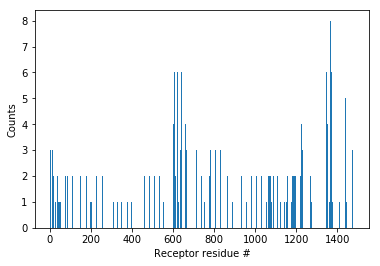

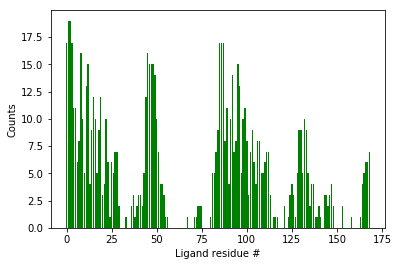

In [21]:
#returns histograms of aggregate docking counts for set of docking solutions for both receptor and ligand by residue position.
#Also outputs receptor residues, receptor counts, ligand residues, and ligand counts - these are aggregate data for set of 
#docking solutions.

r_resis, r_counts, l_resis, l_counts, actual_l_resis = docking_histograms(aggregate_residues, path, l_chains)

#### Count up all atom contacts for receptor and ligand to feed into heatmap construction

In [22]:
[receptor_atoms, receptor_atom_counts, 
 actual_ligand_atoms, ligand_atoms, ligand_atom_counts] = atom_contacts_parser(aggregate_contacts, path, l_chains)

#### Construct heatmaps

In [23]:
heatmap(path, r_chains, l_chains)

In [24]:
heatmap(path, r_chains, l_chains, plot_receptor=False, plot_ligand=True)